Практический проект по предсказанию рейтинга фильма.

Цель: В этом задании вам предстоит поработать с методом tf-idf чтобы извлечь признаки из текста для построения моделей.

1. Скачайте данные по отзывам с сайта IMDB (https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews), в которых для каждого отзыва поставлена семантическая оценка - "позитивный" или "негативный". 

2. Разбейте данные на train/test, отложив 30% наблюдений для тестирования (датасет достаточно большой и выборка сбалансированная, так что можно не беспокоиться о стратификации)

3. Примените tf-idf преобразование. Используйте как отдельные токены, так и биграммы, отсейте английские стоп-слова, а также слова, которые встречаются реже, чем в двух отзывах, или чаще, чем в 50% отзывов (параметры min/max_df), не забудьте убрать l2 регуляризацию, которая по умолчанию включена

4. Постройте логистическую регрессию с настройкой параметра регуляризации, оцените качество при помощи метрик для бинарной классификации

5. Визуализируйте получившиеся коэффициенты регрессии (возьмите топ-50 слов). Какие слова наиболее характерны для отрицательных отзывов? Какие для положительных?

In [189]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import json

from sklearn.linear_model import SGDClassifier, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import nltk

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [190]:
data = pd.read_csv('IMDB Dataset.csv')
data


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [191]:
data['sentiment'].value_counts()


negative    25000
positive    25000
Name: sentiment, dtype: int64

# ML

## Стемминг

In [192]:
df_train_stem, df_test_stem = train_test_split(data, test_size = 0.3, random_state = 42)
df_train_stem.reset_index(drop = True, inplace = True)
df_test_stem.reset_index(drop = True, inplace = True)
print(df_train.shape, df_test.shape)


(35000, 2) (15000, 2)


In [193]:
stop = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.snowball.EnglishStemmer('english')

def data_Stemmer(text):
    return ' '.join([stemmer.stem(word) for word in text.split(' ') if word not in stop])


In [194]:
df_train_stem['review'][0]


'As much as I love trains, I couldn\'t stomach this movie. The premise that one could steal a locomotive and "drive" from Arkansas to Chicago without hitting another train along the way has to be right up there on the Impossible Plot lines hit board. Imagine two disgruntled NASA employees stealing the "crawler" that totes the shuttles to and fro and driving it to New York and you get the idea.<br /><br />Having said all that, it\'s a nice try. Wilford Brimely is at his Quaker Oats best, and Levon Helm turns a good performance as his dimwitted but well-meaning sidekick. Bob Balaban is suitably wormy as the Corporate Guy, and the "little guy takes on Goliath" story gets another airing.'

In [195]:
%%time
df_train_stem['review'] = df_train_stem['review'].apply(lambda x: data_Stemmer(x))


CPU times: user 1min 33s, sys: 96.9 ms, total: 1min 34s
Wall time: 1min 34s


In [196]:
df_train_stem['review'][0]


'as much i love trains, i stomach movie. the premis one could steal locomot "drive" arkansa chicago without hit anoth train along way right imposs plot line hit board. imagin two disgruntl nasa employe steal "crawler" tote shuttl fro drive new york get idea.<br /><br />have said that, nice try. wilford brime quaker oat best, levon helm turn good perform dimwit well-mean sidekick. bob balaban suitabl wormi corpor guy, "littl guy take goliath" stori get anoth airing.'

In [197]:
%%time
df_test_stem['review'] = df_test_stem['review'].apply(lambda x: data_Stemmer(x))


CPU times: user 40.3 s, sys: 37.4 ms, total: 40.4 s
Wall time: 40.4 s


In [198]:
X_train = df_train_stem['review']
y_train = df_train_stem['sentiment']
X_test = df_test_stem['review']
y_test = df_test_stem['sentiment']


In [199]:
def visualize_coefficients_all(coef, feature_names, title, plot_num, n_top_features = 50):
    interesting_coefficients = np.argsort(abs(coef))[-n_top_features:]
    
    plt.figure(figsize=(15, 15))
    plt.subplot(510 + plot_num + 1)
    colors = ["lightblue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(n_top_features), coef[interesting_coefficients], color = colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + n_top_features), 
               feature_names[interesting_coefficients], rotation = 60, ha = "right", fontsize=14);
    plt.title(title)
    

### Для отдельных токенов


In [212]:
%%time
tf_vectorizer_1 = TfidfVectorizer(stop_words = stop, ngram_range = (1, 1), 
                                  min_df = (2 / len(X_train) / 100), max_df = 0.50, norm = None)

X_train_tfidf = tf_vectorizer_1.fit_transform(X_train)
X_test_tfidf = tf_vectorizer_1.transform(X_test)
X_train_tfidf.shape, X_test_tfidf.shape


CPU times: user 7.34 s, sys: 142 ms, total: 7.48 s
Wall time: 7.02 s


((35000, 83253), (15000, 83253))

In [213]:
%%time
logit_cv_1 = LogisticRegressionCV(Cs = 5, n_jobs = -1)
logit_cv_1.fit(X_train_tfidf, y_train)

print('in train: ', accuracy_score(logit_cv_1.predict(X_train_tfidf), y_train))
print('in test:  ', accuracy_score(logit_cv_1.predict(X_test_tfidf), y_test))

print(classification_report(logit_cv_1.predict(X_test_tfidf), y_test))


in train:  0.9938857142857143
in test:   0.8890666666666667
              precision    recall  f1-score   support

    negative       0.88      0.89      0.89      7283
    positive       0.90      0.88      0.89      7717

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000

CPU times: user 9.15 s, sys: 413 ms, total: 9.57 s
Wall time: 24.2 s


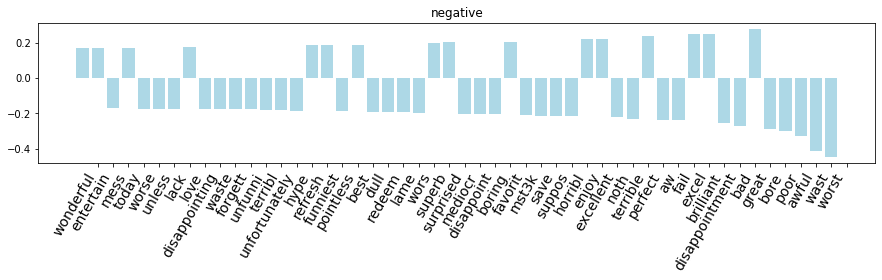

In [214]:
visualize_coefficients_all(logit_cv_1.coef_[0,:], tf_vectorizer_1.get_feature_names(), 
                           title = titles[0], plot_num = 0)


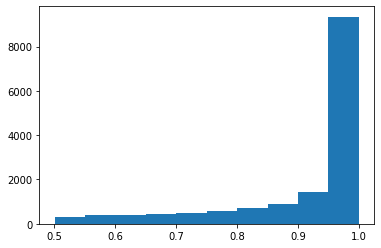

In [216]:
plt.hist(np.max(logit_cv_1.predict_proba(X_test_tfidf), axis=1));


### Для отдельных токенов и биграмм

In [217]:
%%time
tf_vectorizer_1_2 = TfidfVectorizer(stop_words = stop, ngram_range = (1, 2), 
                                min_df = (2 / len(X_train) / 100), max_df = 0.50, norm = None)

X_train_tfidf = tf_vectorizer_1_2.fit_transform(X_train)
X_test_tfidf = tf_vectorizer_1_2.transform(X_test)
X_train_tfidf.shape, X_test_tfidf.shape


CPU times: user 31.2 s, sys: 793 ms, total: 32 s
Wall time: 30.9 s


((35000, 2239194), (15000, 2239194))

In [218]:
%%time
logit_cv_12 = LogisticRegressionCV(Cs = 5, n_jobs = -1)
logit_cv_12.fit(X_train_tfidf, y_train)

print('in train: ', accuracy_score(logit_cv_12.predict(X_train_tfidf), y_train))
print('in test:  ', accuracy_score(logit_cv_12.predict(X_test_tfidf), y_test))

print(classification_report(logit_cv_12.predict(X_test_tfidf), y_test))


in train:  1.0
in test:   0.9023333333333333
              precision    recall  f1-score   support

    negative       0.89      0.91      0.90      7248
    positive       0.91      0.89      0.90      7752

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000

CPU times: user 49.2 s, sys: 2.87 s, total: 52.1 s
Wall time: 4min 22s


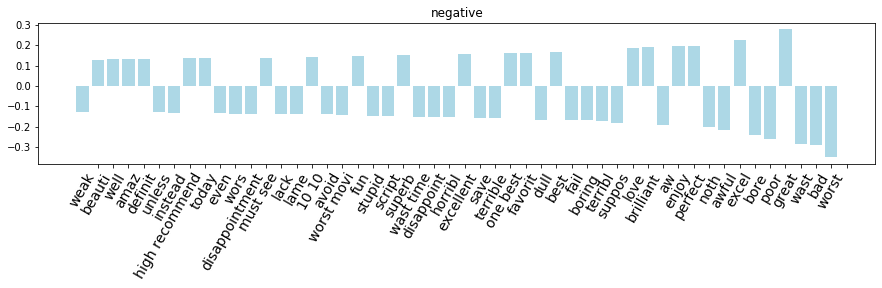

In [219]:
visualize_coefficients_all(logit_cv_12.coef_[0,:], tf_vectorizer_1_2.get_feature_names(), 
                       title = titles[0], plot_num = 0)


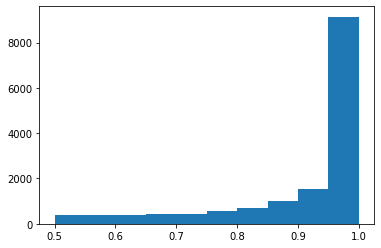

In [220]:
plt.hist(np.max(logit_cv_12.predict_proba(X_test_tfidf), axis=1));


### Для биграмм

In [221]:
%%time
tf_vectorizer_22 = TfidfVectorizer(stop_words = stop, ngram_range = (2, 2),
                                min_df = (2 / len(X_train) / 100), max_df = 0.50, norm = None)

X_train_tfidf = tf_vectorizer_22.fit_transform(X_train)
X_test_tfidf = tf_vectorizer_22.transform(X_test)
X_train_tfidf.shape, X_test_tfidf.shape


CPU times: user 25.1 s, sys: 722 ms, total: 25.8 s
Wall time: 24.6 s


((35000, 2155941), (15000, 2155941))

In [222]:
%%time
logit_cv_22 = LogisticRegressionCV(Cs = 3, n_jobs = -1)
logit_cv_22.fit(X_train_tfidf, y_train)

print('in train: ', accuracy_score(logit_cv_22.predict(X_train_tfidf), y_train))
print('in test:  ', accuracy_score(logit_cv_22.predict(X_test_tfidf), y_test))

print(classification_report(logit_cv_22.predict(X_test_tfidf), y_test))


in train:  1.0
in test:   0.8746
              precision    recall  f1-score   support

    negative       0.85      0.89      0.87      7138
    positive       0.89      0.86      0.88      7862

    accuracy                           0.87     15000
   macro avg       0.87      0.88      0.87     15000
weighted avg       0.88      0.87      0.87     15000

CPU times: user 51.6 s, sys: 2.33 s, total: 53.9 s
Wall time: 1min 39s


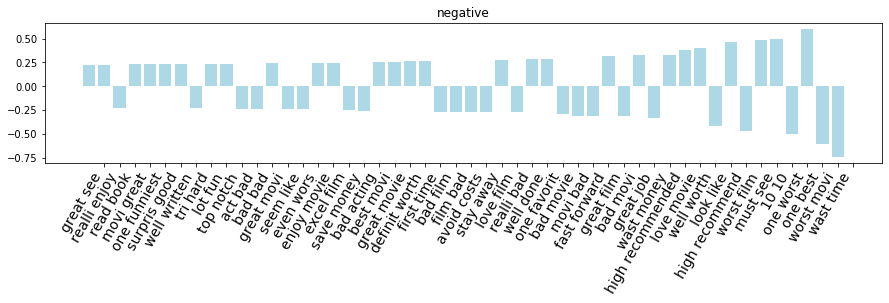

In [223]:
visualize_coefficients_all(logit_cv_22.coef_[0,:], tf_vectorizer_22.get_feature_names(), 
                           title = titles[0], plot_num = 0)


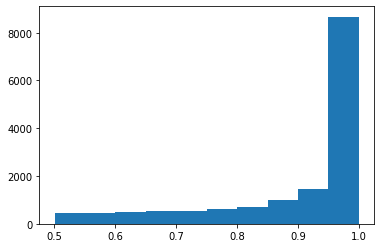

In [224]:
plt.hist(np.max(logit_cv_22.predict_proba(X_test_tfidf), axis=1));


## Лемматизация

In [225]:
df_train, df_test = train_test_split(data, test_size = 0.3, random_state = 42)
df_train.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)
print(df_train.shape, df_test.shape)


(35000, 2) (15000, 2)


In [230]:
lemmatizer = nltk.stem.WordNetLemmatizer()
def data_Stemmer(text):
    return ' '.join([lemmatizer.lemmatize(word.lower()) for word in text.split(' ') if word not in stop])


In [231]:
df_train['review'][0]


'As much I love trains, I stomach movie. The premise one could steal locomotive "drive" Arkansas Chicago without hitting another train along way right Impossible Plot line hit board. Imagine two disgruntled NASA employee stealing "crawler" tote shuttle fro driving New York get idea.<br /><br />Having said that, nice try. Wilford Brimely Quaker Oats best, Levon Helm turn good performance dimwitted well-meaning sidekick. Bob Balaban suitably wormy Corporate Guy, "little guy take Goliath" story get another airing.'

In [232]:
%%time
df_train['review'] = df_train['review'].apply(lambda x: data_Stemmer(x))
df_train['review'][0]


CPU times: user 35.3 s, sys: 59.2 ms, total: 35.4 s
Wall time: 35.4 s


'a much i love trains, i stomach movie. the premise one could steal locomotive "drive" arkansas chicago without hitting another train along way right impossible plot line hit board. imagine two disgruntled nasa employee stealing "crawler" tote shuttle fro driving new york get idea.<br /><br />having said that, nice try. wilford brimely quaker oat best, levon helm turn good performance dimwitted well-meaning sidekick. bob balaban suitably wormy corporate guy, "little guy take goliath" story get another airing.'

In [233]:
X_train = df_train['review']
y_train = df_train['sentiment']
X_test = df_test['review']
y_test = df_test['sentiment']


### Для отдельных токенов

In [253]:
%%time
tf_vectorizer_1 = TfidfVectorizer(stop_words = stop, ngram_range = (1, 1), 
                                  min_df = (2 / len(X_train) / 100), max_df = 0.50, norm = None)

X_train_tfidf = tf_vectorizer_1.fit_transform(X_train)
X_test_tfidf = tf_vectorizer_1.transform(X_test)
X_train_tfidf.shape, X_test_tfidf.shape


CPU times: user 8.67 s, sys: 212 ms, total: 8.88 s
Wall time: 8.44 s


((35000, 85485), (15000, 85485))

In [254]:
%%time
logit_cv_lem_1 = LogisticRegressionCV(Cs = 3, n_jobs = -1)
logit_cv_lem_1.fit(X_train_tfidf, y_train)

print('in train: ', accuracy_score(logit_cv_lem_1.predict(X_train_tfidf), y_train))
print('in test:  ', accuracy_score(logit_cv_lem_1.predict(X_test_tfidf), y_test))

print(classification_report(logit_cv_lem_1.predict(X_test_tfidf), y_test))


in train:  0.9139142857142857
in test:   0.8876
              precision    recall  f1-score   support

    negative       0.86      0.90      0.88      7089
    positive       0.91      0.87      0.89      7911

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000

CPU times: user 3.31 s, sys: 283 ms, total: 3.59 s
Wall time: 16 s


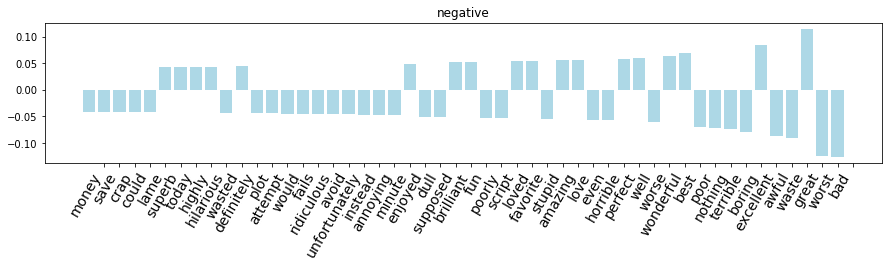

In [255]:
visualize_coefficients_all(logit_cv_lem_1.coef_[0,:], tf_vectorizer_1.get_feature_names(), 
                       title = titles[0], plot_num = 0)


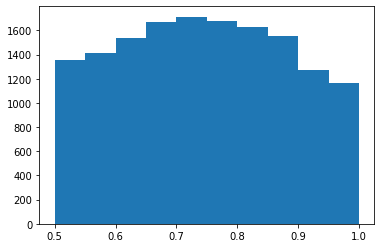

In [256]:
plt.hist(np.max(logit_cv_lem_1.predict_proba(X_test_tfidf), axis=1));


### Для отдельных токенов и биграмм

In [238]:
%%time
tf_vectorizer_1_2 = TfidfVectorizer(stop_words = stop, ngram_range = (1, 2), 
                                min_df = (2 / len(X_train) / 100), max_df = 0.50, norm = None)

X_train_tfidf = tf_vectorizer_1_2.fit_transform(X_train)
X_test_tfidf = tf_vectorizer_1_2.transform(X_test)
X_train_tfidf.shape, X_test_tfidf.shape


CPU times: user 30.3 s, sys: 707 ms, total: 31 s
Wall time: 29.7 s


((35000, 2325077), (15000, 2325077))

In [239]:
%%time
logit_cv_lem12 = LogisticRegressionCV(Cs = 3, n_jobs = -1)
logit_cv_lem12.fit(X_train_tfidf, y_train)

print('in train: ', accuracy_score(logit_cv_lem12.predict(X_train_tfidf), y_train))
print('in test:  ', accuracy_score(logit_cv_lem12.predict(X_test_tfidf), y_test))

print(classification_report(logit_cv_lem12.predict(X_test_tfidf), y_test))


in train:  1.0
in test:   0.9019333333333334
              precision    recall  f1-score   support

    negative       0.89      0.91      0.90      7214
    positive       0.92      0.89      0.90      7786

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000

CPU times: user 25.9 s, sys: 2.03 s, total: 27.9 s
Wall time: 2min 40s


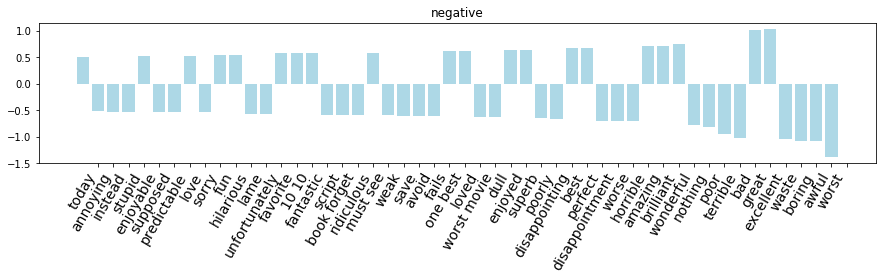

In [240]:
visualize_coefficients_all(logit_cv_lem12.coef_[0,:], tf_vectorizer_1_2.get_feature_names(), 
                       title = titles[0], plot_num = 0)


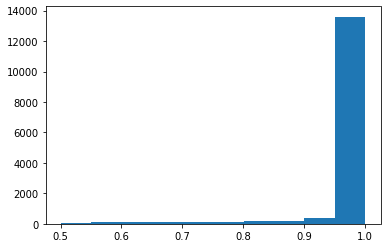

In [241]:
plt.hist(np.max(logit_cv_lem12.predict_proba(X_test_tfidf), axis=1));


### Для биграмм

In [242]:
%%time
tf_vectorizer_22 = TfidfVectorizer(stop_words = stop, ngram_range = (2, 2),
                                min_df = (2 / len(X_train) / 100), max_df = 0.50, norm = None)

X_train_tfidf = tf_vectorizer_22.fit_transform(X_train)
X_test_tfidf = tf_vectorizer_22.transform(X_test)
X_train_tfidf.shape, X_test_tfidf.shape


CPU times: user 25 s, sys: 551 ms, total: 25.5 s
Wall time: 24.2 s


((35000, 2239592), (15000, 2239592))

In [243]:
%%time
logit_cv_lem22 = LogisticRegressionCV(Cs = 3, n_jobs = -1)
logit_cv_lem22.fit(X_train_tfidf, y_train)

print('in train: ', accuracy_score(logit_cv_lem22.predict(X_train_tfidf), y_train))
print('in test:  ', accuracy_score(logit_cv_lem22.predict(X_test_tfidf), y_test))

print(classification_report(logit_cv_lem22.predict(X_test_tfidf), y_test))


in train:  1.0
in test:   0.8696
              precision    recall  f1-score   support

    negative       0.84      0.89      0.86      7021
    positive       0.90      0.85      0.87      7979

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000

CPU times: user 46.6 s, sys: 2.36 s, total: 49 s
Wall time: 1min 42s


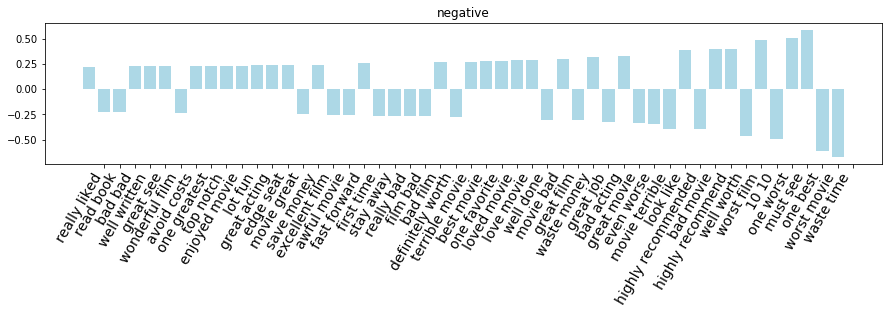

In [244]:
visualize_coefficients_all(logit_cv_lem22.coef_[0,:], tf_vectorizer_22.get_feature_names(), 
                       title = titles[0], plot_num = 0)


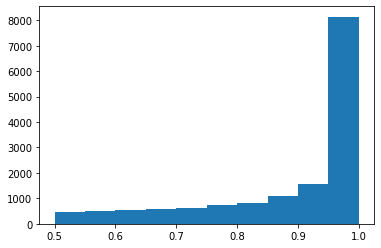

In [245]:
plt.hist(np.max(logit_cv_lem22.predict_proba(X_test_tfidf), axis=1));


# Выводы

In [252]:
stem = [0.8890666666666667, 0.9023333333333333, 0.8746]
lem = [0.8876, 0.9019333333333334, 0.8696]
columns = ['отдельные слова', 'отдельные слова и биграммы', 'только биграммы']
itog = pd.DataFrame([stem, lem], columns = columns, index = ['stem', 'lem'])
itog


,отдельные слова,отдельные слова и биграммы,только биграммы
stem,0.889067,0.902333,0.8746
lem,0.887600,0.901933,0.8696


1. Результаты при Стемминге и Лемматизации получились примерно сопоставимы. Самое интересное, что при Лемматизации результат везде чуть ниже на примерно 0.2%.
2. Лучший результат дало разбиение данных на отдельные токены и биграммы. Причем в ТОП50 слов в основнов одтельные слова, биграмм всего 3-4.
3. По гистограммам распределения вероятностей предсказания видно, что все модели очень уверенны в предскании - бОльшая часть равна единице. Кроме случая, когда мы используем для обучения данные после Лемматизации и разбивке по отдельным словам.
4. Топ слов из положительных отзывов: great, excel, perfect enjoy, brilliant, love.
5. Топ слов из отрицательных отзывов: worst, bad, wast, poor, bore
